# **Proyecto 1: Minería de Datos: Texto para Turismo**
## **Procesamiento de Lenguaje natural**
## **Alan García Zermeño**
## **17 de abril de 2023**


---


### Analizamos los datos recopilados para 10 destinos turísicos en la ciudad de Guanajuato conformados por: 
### 1. Basilica Colegiata
### 2. Mercado Hidalgo
### 3. Casa de Diego Rivera
### 4. Universidad de Guanajuato
### 5. Alhóndiga
### 6. Teatro Juárez
### 7. Jardín de la Unión
### 8. Callejón del beso
### 9. Monumento Pípila
### 10. Museo de las momias

### Para ello, preprocesamos la base de datos y nos quedamos con las entradas escritas en **español**, para hacer un análisis de texto adecuado.

In [ ]:
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from nltk.corpus import stopwords
nltk.download("stopwords")
stopwords = set(stopwords.words('spanish', 'english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataTurismo = [pd.read_excel("/content/drive/MyDrive/Colab Notebooks/turismo/Opiniones Tripadvisor_nlp2023.xlsx", sheet_name=i, header=0) for i in range(10)]
dataTurismo = [dataTurismo[i][dataTurismo[i].Idioma == "Español"] for i in range(10)]
places = ["Basilica Colegiata","Mercado Hidalgo","Casa de Diego Rivera","Universidad de Guanajuato","Alhóndiga","Teatro Juárez","Jardín de la Unión","Callejón del beso","Monumento Pípila","Museo de las momias"]
display(dataTurismo[5])

Género  Edad Nacional ó Internacional Calificación  Escala  \
10    Masculino  61.0                 Nacional    Excelente       5   
11     Femenino  33.0                 Nacional    Excelente       5   
12     Femenino  41.0                 Nacional    Excelente       5   
13     Femenino  35.0            Internacional    Excelente       5   
15     Femenino  19.0                 Nacional    Excelente       5   
...         ...   ...                      ...          ...     ...   
996    Femenino  27.0                 Nacional    Muy bueno       4   
997    Femenino  42.0                 Nacional    Excelente       5   
999    Femenino  35.0                 Nacional    Muy bueno       4   
1002   Femenino  30.0            Internacional    Excelente       5   
1006   Femenino  35.0                 Nacional    Excelente       5   

      Número de aportaciones  \
10                         6   
11                        49   
12                        43   
13                        12   
15                        96   
...                      ...   
996                       21   
997                       55   
999                       45   
1002                      30   
1006                     424   

                                   Título de la opinión  \
10                                     "Muy pintoresco"   
11                                         "Majestuoso"   
12                                             "Divino"   
13      ¡UN EJEMPLAR DE LA HISTORIA DE NUESTRO MEXICO!"   
15                               "Hermoso y conservado"   
...                                                 ...   
996                                  "¡Precioso lugar!"   
997      "Un teatro hermoso de principios del siglo XX"   
999   "Fui a una puesta en escena de ballet contempo...   
1002                         "Busquen la visita guiada"   
1006  "Arquitectura griega clásica junto al arte bar...   

                                                Opinión            País  \
10    "Buen edificio… cuidado y mantenido, se amalga...          México   
11    "Sin duda alguna, un lugar que no puedes dejar...          México   
12    "Muy bien conservado vale la pena entrar a ver...          México   
13    "Conservador, lleno de historia, y arte pintur...  Estados Unidos   
15    "Un lugar histórico y muy bello. En ocasiones ...          México   
...                                                 ...             ...   
996   "Lamentablemente las horas a las que iba no pu...          México   
997   "En sí el teatro es una belleza enmarcada en u...          México   
999   "Estuvo muy divertida, ya que estaba dirigida ...          México   
1002  "La verdad ya antes habíamos visitado Guanajua...  Estados Unidos   
1006  "El Teatro Juárez nos recuerda las elegantes c...          México   

       Idioma Dispositivo      Fecha  
10    Español       Móvil 2018-04-09  
11    Español       Móvil 2018-04-05  
12    Español       Móvil 2018-03-29  
13    Español          PC 2018-03-28  
15    Español          PC 2018-03-20  
...       ...         ...        ...  
996   Español          PC 2011-11-25  
997   Español          PC 2011-11-19  
999   Español          PC 2011-11-10  
1002  Español          PC 2011-09-28  
1006  Español          PC 2010-04-01  

[657 rows x 12 columns]



---
## **1**. A modo de exploración mostramos algunas estadísticas relevantes respecto a la base de datos usada:

### a) Promedios de calificación por lugar y desviación estandar.

In [ ]:
califmean = [np.mean(dataTurismo[i].Escala) for i in range(10)]
califstd = [np.std(dataTurismo[i].Escala) for i in range(10)]
print('\033[1m' + "PROMEDIOS DE CALIFICACIÓN POR LUGAR\n\n" +'{:<4} {:<27} {:<7} {:}'.format("-","LUGAR TURÍSTICO","MEDIA","STD")+ '\033[0m')
for i in range(10): print('{:<4} {:<27} {:<7} {:}'.format(i+1,places[i],round(califmean[i],3),round(califstd[i],3)))

PROMEDIOS DE CALIFICACIÓN POR LUGAR

-    LUGAR TURÍSTICO             MEDIA   STD
1    Basilica Colegiata          4.519   0.663
2    Mercado Hidalgo             3.902   0.973
3    Casa de Diego Rivera        4.304   0.789
4    Universidad de Guanajuato   4.679   0.529
5    Alhóndiga                   4.441   0.775
6    Teatro Juárez               4.767   0.464
7    Jardín de la Unión          4.597   0.601
8    Callejón del beso           4.075   0.934
9    Monumento Pípila            4.336   0.783
10   Museo de las momias         3.645   1.129


### b) Basado en palabras: longitud promedio de opiniones y desviaciones estándar

In [ ]:
opinmean = [np.mean(np.array([len(dataTurismo[j].iloc[i]["Opinión"].split()) for i in range(len(dataTurismo[j]))])) for j in range(10)]
opinstd = [np.std(np.array([len(dataTurismo[j].iloc[i]["Opinión"].split()) for i in range(len(dataTurismo[j]))])) for j in range(10)]
print('\033[1m' + "PROMEDIOS DE LONGITUD DE OPINIÓN (PALABRA) POR LUGAR\n\n" +'{:<4} {:<27} {:<7} {:}'.format("-","LUGAR TURÍSTICO","MEDIA","STD")+ '\033[0m')
for i in range(10): print('{:<4} {:<27} {:<7} {:}'.format(i+1,places[i],round(opinmean[i],3),round(opinstd[i],3)))

PROMEDIOS DE LONGITUD DE OPINIÓN (PALABRA) POR LUGAR

-    LUGAR TURÍSTICO             MEDIA   STD
1    Basilica Colegiata          34.481  24.047
2    Mercado Hidalgo             40.454  23.062
3    Casa de Diego Rivera        43.933  27.54
4    Universidad de Guanajuato   32.907  18.632
5    Alhóndiga                   41.028  25.252
6    Teatro Juárez               37.714  24.248
7    Jardín de la Unión          37.37   25.865
8    Callejón del beso           43.328  32.785
9    Monumento Pípila            41.258  27.386
10   Museo de las momias         51.359  39.685


### c) Histogramas de edades de opiniones por lugar

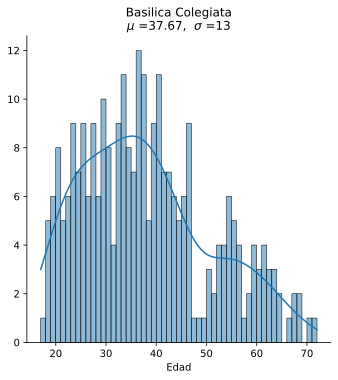

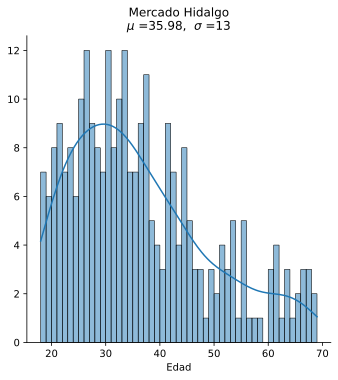

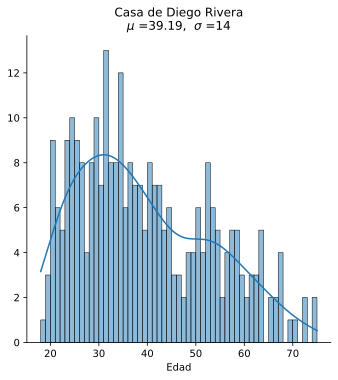

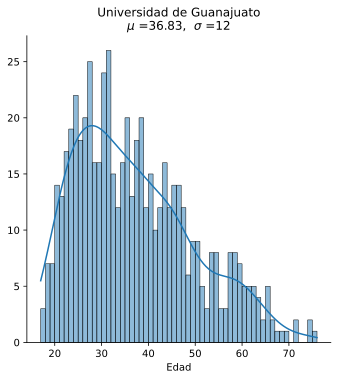

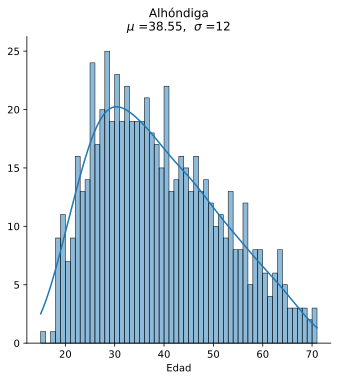

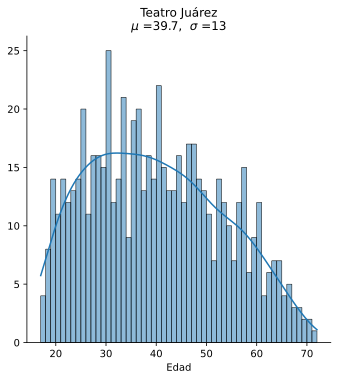

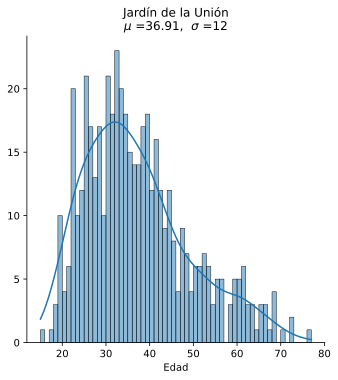

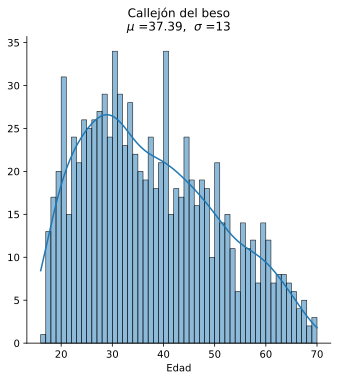

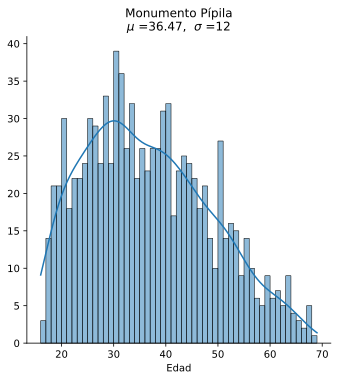

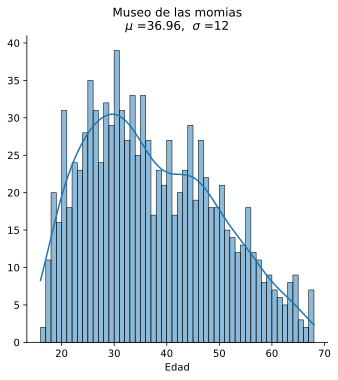

In [ ]:
for j in range(10):
  sns.displot(dataTurismo[j].Edad,bins = int(max(dataTurismo[j].Edad)-min(dataTurismo[j].Edad)),kde = True)
  plt.ylabel("");plt.title(places[j]+"\n$\mu$ =" + str(round(np.mean(dataTurismo[j].Edad),2)) + ",  $\sigma$ =" + str(round(np.std(dataTurismo[j].Edad))))
plt.show()

### d) Histograma de tipo de visitantes (nacional o internacional) por lugar.

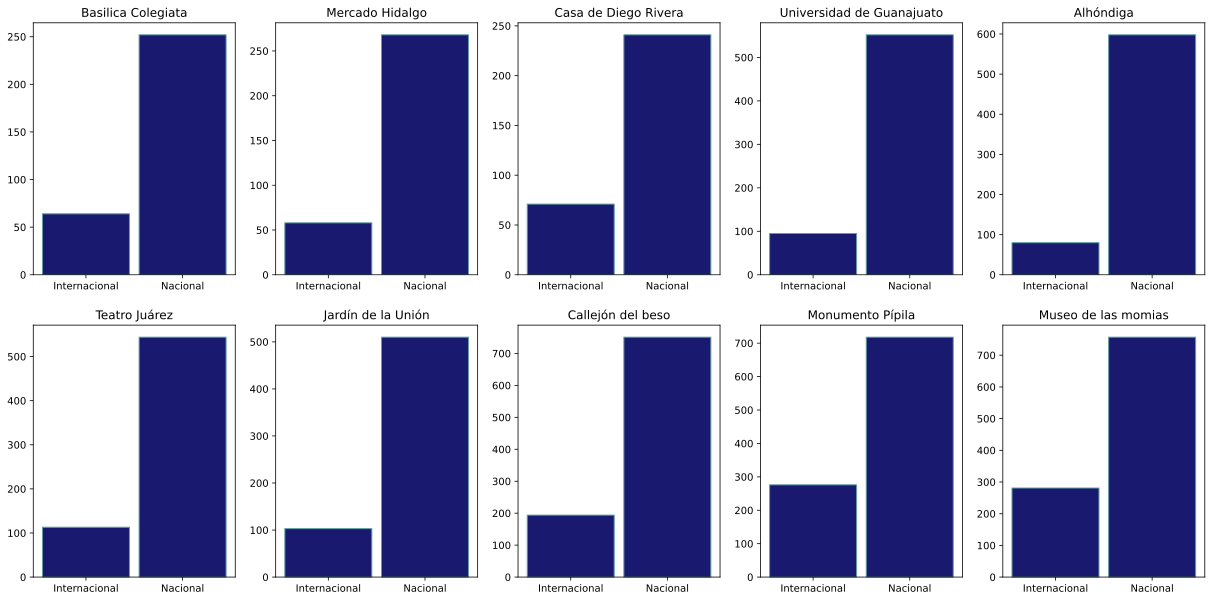

In [ ]:
plt.figure(figsize=(21, 10))
for i in range(10):
  plt.subplot(2, 5, i+1);plt.title(places[i]);plt.hist(sorted(dataTurismo[i]["Nacional ó Internacional"]),2,color = "midnightblue",rwidth=0.9,ec ="cadetblue");plt.xticks([0.25,0.75],["Internacional","Nacional"])
plt.show()

### e) Histograma de participación por género por lugar.

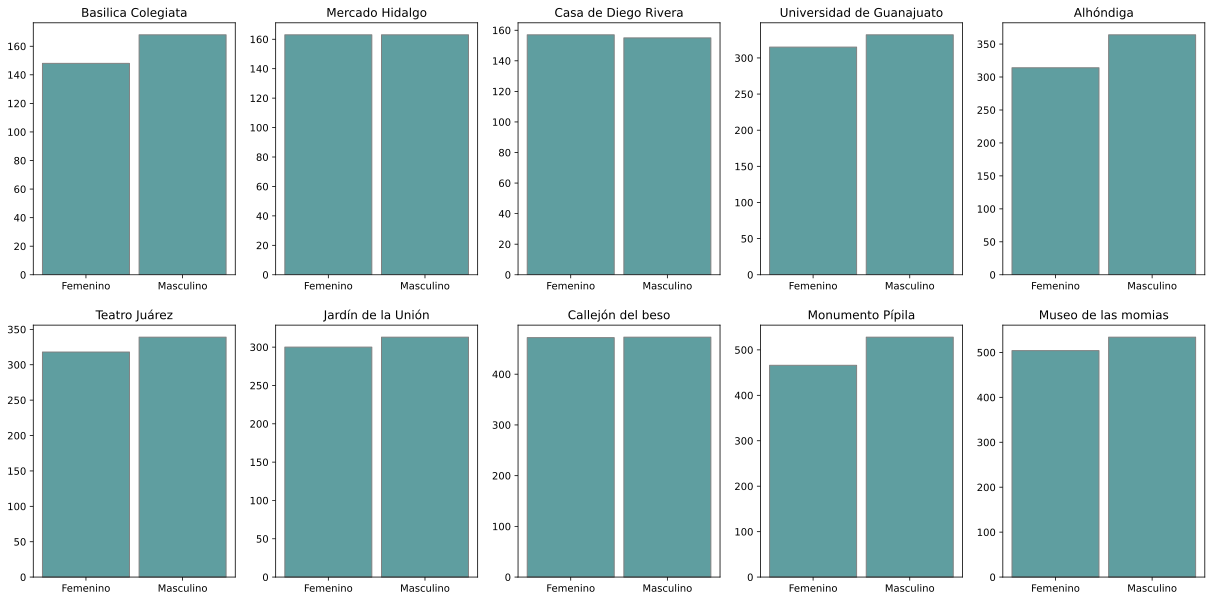

In [ ]:
plt.figure(figsize=(21, 10))
for i in range(10):
  plt.subplot(2, 5, i+1);plt.title(places[i]);plt.hist(sorted(dataTurismo[i]["Género"]),2,color = "cadetblue",rwidth=0.9,ec ="gray");plt.xticks([0.25,0.75],["Femenino","Masculino"])
plt.show()

### f) Promedios de calificación por género y por lugar y su desviación estandar.

In [ ]:
califmeanH = [np.mean(dataTurismo[i].Escala[dataTurismo[i].Género == "Masculino"]) for i in range(10)]
califmeanM = [np.mean(dataTurismo[i].Escala[dataTurismo[i].Género == "Femenino"]) for i in range(10)]
califstdH = [np.std(dataTurismo[i].Escala[dataTurismo[i].Género == "Masculino"]) for i in range(10)]
califstdM = [np.std(dataTurismo[i].Escala[dataTurismo[i].Género == "Femenino"]) for i in range(10)]
print('\033[1m' + "PROMEDIOS DE CALIFICACIÓN POR LUGAR\n\n" +'{:<4} {:<27} {:<7} {:<7} {:<7} {:}'.format("-","LUGAR TURÍSTICO","MEDIA_H","STD_H","MEDIA_M","STD_M")+ '\033[0m')
for i in range(10): print('{:<4} {:<27} {:<7} {:<7} {:<7} {:}'.format(i+1,places[i],round(califmeanH[i],3),round(califstdH[i],3),round(califmeanM[i],3),round(califstdM[i],3)))

PROMEDIOS DE CALIFICACIÓN POR LUGAR

-    LUGAR TURÍSTICO             MEDIA_H STD_H   MEDIA_M STD_M
1    Basilica Colegiata          4.47    0.698   4.574   0.616
2    Mercado Hidalgo             3.902   0.973   3.902   0.973
3    Casa de Diego Rivera        4.277   0.815   4.331   0.76
4    Universidad de Guanajuato   4.648   0.559   4.711   0.493
5    Alhóndiga                   4.453   0.76    4.427   0.792
6    Teatro Juárez               4.761   0.46    4.774   0.468
7    Jardín de la Unión          4.559   0.607   4.637   0.593
8    Callejón del beso           4.057   0.933   4.093   0.934
9    Monumento Pípila            4.29    0.799   4.388   0.762
10   Museo de las momias         3.624   1.121   3.667   1.137


### Codificamos ahora un vector de calificación, donde 1 y 2 es malo, 3 es regular y 4, 5 es bueno y preprocesamos el texto (Quitando comillas y stopwords) de cada lugar para poder realizar bolsas de palabras. Se usará 0 para bueno, 1 para regular y 2 para malo. 

In [ ]:
califCod = [np.zeros(len(dataTurismo[i].Escala)) for i in range(10)]
opinions = [[] for i in range(10)]
for i in range(10):
    for k,j in enumerate(dataTurismo[i].Escala):
      opinions[i] += [dataTurismo[i]["Opinión"].iloc[k].replace('"','')]
      if j == 3:
        califCod[i][k] = 1
      if j < 3:
        califCod[i][k] = 2

In [ ]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

corpus_palabras = [[] for i in range(10)]
for i in range(10):
  for doc in opinions[i]:
    corpus_palabras[i] += tokenizer.tokenize(doc)

fdist = [nltk.FreqDist(corpus_palabras[i]) for i in range(10)]

In [ ]:
def sortFreqDist(freqdict):
  aux = [key for key in freqdict]
  aux.sort()
  aux.reverse()
  return aux

V = [sortFreqDist(fdist[i])[:1500] for i in range(10)]

In [ ]:
dict_indices = [dict() for i in range(10)]

for i in range(10):
  cont = 0
  for word in V[i]:
    dict_indices[i][word] = cont
    cont += 1

---
## **2** Utilizamos ahora una bolsa de palabras de frecuencia para cada sitio y usamos SelectKbest para quedamor con las 200 palabras más relevantes y usamos wordcloud para mostrar las nubes de palabras formadas para cada lugar.

In [ ]:
def build_bow_trf(tr_txt,V,dict_indices):
  BOW = np.zeros((len(tr_txt),len(V)),dtype = float)

  cont_doc = 0
  for tr in tr_txt:
    fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))

    for word in fdist_doc:
      if word in dict_indices:
        BOW[cont_doc, dict_indices[word]] = fdist_doc[word]
    
    cont_doc+=1
  
  return BOW

BOW_trip = [build_bow_trf(opinions[i], V[i], dict_indices[i]) for i in range (10)]
BOW_trip = [preprocessing.normalize(BOW_trip[i], norm = 'l2') for i in range(10)]

In [ ]:
#Escoger las mejores k features
best = [0 for i in range(10)]
for i in range(10):
  feats = SelectKBest(chi2, k=200)
  feats.fit(BOW_trip[i], califCod[i])
  best[i] = feats.get_support(indices=True)    

In [ ]:
dict_indice_invertido = [{} for i in range(10)]
for i in range(10):
  for w in dict_indices[i]:
    dict_indice_invertido[i][dict_indices[i][w]] = w

t_words = [[dict_indice_invertido[i][index] for index in best[i]] for i in range(10)]
#t_words[0][:20]

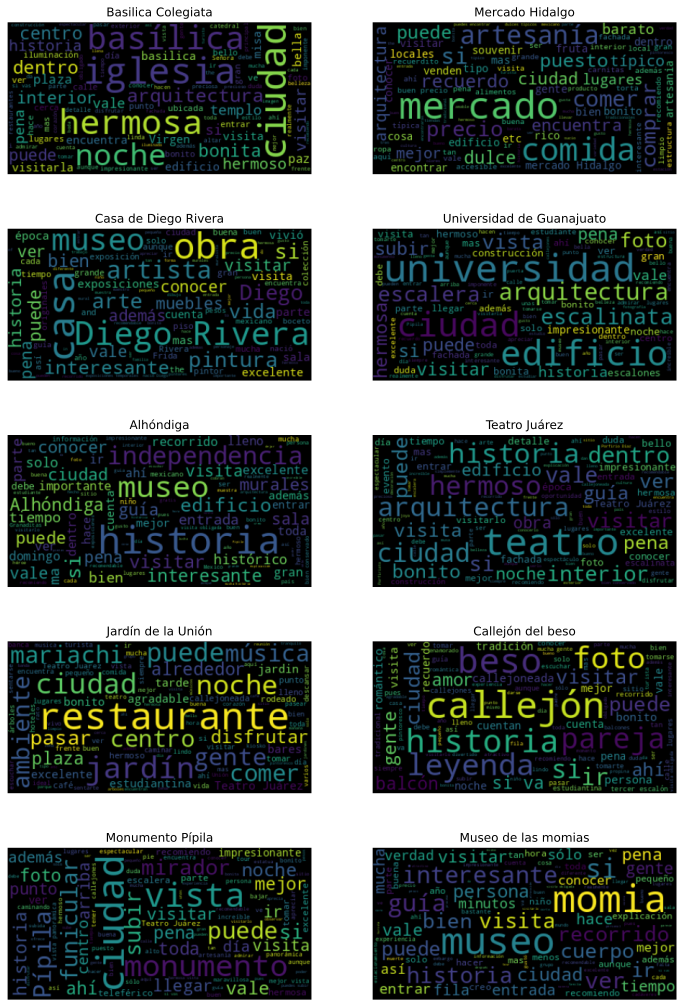

In [ ]:
# Create and generate a word cloud image:
plt.figure(figsize=(12, 18))
stopwords.update(["lugar","Guanajuato","México"])

# Display the generated image:
for i in range(10):
  wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="black").generate(" ".join(opinions[i]))
  plt.subplot(5,2,i+1);plt.title(places[i])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
plt.savefig('foo.png')
plt.show()



---
## **3**. Para cada uno de los 10 sitios, descubrimos los 3 componentes principales con LSA (sklearn) para diferentes subgrupos de la base de datos, e imprimimos en cada uno de ellos las 10 palabras más relevantes según cada tópico.

### a) Género masculino:

In [ ]:
def filter(dataTurismo,categoria,subgrupo):
  if categoria == None:
    pass
  else:
    dataTurismo = [dataTurismo[i][dataTurismo[i][categoria] == subgrupo] for i in range(10)]

  opinions = [dataTurismo[i][["Opinión","Escala","Fecha"]] for i in range(10)]
  for i in range(10):
    for k,j in enumerate(dataTurismo[i].Escala):
      opinions[i]["Opinión"].iloc[k] = dataTurismo[i]["Opinión"].iloc[k].replace('"','')
  return(opinions)

In [ ]:
opinions = filter(dataTurismo,'Género','Masculino')
vectorizer = [TfidfVectorizer(min_df = 2,stop_words = 'english',lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
svd = [TruncatedSVD(n_components=3) for i in range(10)]
lsa = [svd[i].fit_transform(BOW_trip[i]) for i in range(10)]
lsa[0].shape

<ipython-input-127-2b5a2faf4c01>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opinions[i]["Opinión"].iloc[k] = dataTurismo[i]["Opinión"].iloc[k].replace('"','')


(168, 3)

In [ ]:
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
dicti = [list(dicti[i].keys()) for i in range(10)]

In [ ]:
enc_matrix = [pd.DataFrame(svd[i].components_,index = ['topic_1','topic_2','topic_3'],columns = dicti[i]).T for i in range(10)]
print(enc_matrix[0].shape)
aux = [np.zeros((3,enc_matrix[i].shape[0])) for i in range(10)]
for k in range(10):
  print("\n",places[k],"\n")
  for j in range(3):
    for i in range(enc_matrix[k].shape[0]):
      aux[k][j][i] = abs(enc_matrix[k].iloc[i][j])#np.linalg.norm(list(enc_matrix.iloc[i]))
    ind = np.argpartition(aux[k][j], -10)[-10:]
    print("Tópico ",j+1,": " ,list(enc_matrix[k].iloc[ind].index))

(455, 3)

 Basilica Colegiata 

Tópico  1 :  ['hacen', 'llama', 'entrada', 'nostálgico', 'atracción', 'mundo', 'te', 'agradable', 'señora', 'edificio']
Tópico  2 :  ['algunos', 'te', 'nostálgico', 'mundo', 'al', 'hacen', 'edificio', 'vida', 'hermoso', 'llama']
Tópico  3 :  ['ella', 'te', 'padre', 'día', 'pequeño', 'nostálgico', 'atracción', 'edificio', 'conservado', 'parte']

 Mercado Hidalgo 

Tópico  1 :  ['precios', 'perfecto', 'souvenires', 'mejores', 'artesanía', 'encontrar', 'recuerditos', 'sus', 'turistas', 'darse']
Tópico  2 :  ['mucho', 'ricas', 'calidad', 'si', 'para', 'precios', 'sus', 'recuerditos', 'turistas', 'souvenires']
Tópico  3 :  ['tanto', 'asi', 'darse', 'recuerda', 'antes', 'mucho', 'turistas', 'mejores', 'visita', 'perfecto']

 Casa de Diego Rivera 

Tópico  1 :  ['superiores', 'mexico', 'país', 'debes', 'muchos', 'posible', 'ampliamente', 'buena', 'lugar', 'minutos']
Tópico  2 :  ['fines', 'distintas', 'arquitectura', 'pero', '30', 'restaurada', 'posible', 'mexi

### b) Género Femenino

In [ ]:
opinions = filter(dataTurismo,'Género','Femenino')
vectorizer = [TfidfVectorizer(min_df = 2,lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
svd = [TruncatedSVD(n_components=3) for i in range(10)]
lsa = [svd[i].fit_transform(BOW_trip[i]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
dicti = [list(dicti[i].keys()) for i in range(10)]

In [ ]:
enc_matrix = [pd.DataFrame(svd[i].components_,index = ['topic_1','topic_2','topic_3'],columns = dicti[i]).T for i in range(10)]
aux = [np.zeros((3,enc_matrix[i].shape[0])) for i in range(10)]
for k in range(10):
  print("\n",places[k],"\n")
  for j in range(3):
    for i in range(enc_matrix[k].shape[0]):
      aux[k][j][i] = abs(enc_matrix[k].iloc[i][j])#np.linalg.norm(list(enc_matrix.iloc[i]))
    ind = np.argpartition(aux[k][j], -10)[-10:]
    print("Tópico ",j+1,": " ,list(enc_matrix[k].iloc[ind].index))


 Basilica Colegiata 

Tópico  1 :  ['maravillosa', 'maría', 'cada', 'histórico', 'parece', 'imprescindible', 'churrigueresco', 'cantera', 'año', 'calle']
Tópico  2 :  ['cada', 'churrigueresco', 'puedes', 'así', 'histórico', 'parece', 'hora', 'azul', 'año', 'virgen']
Tópico  3 :  ['maravillosa', 'azul', 'virgen', 'restos', 'calle', 'maría', 'gran', 'histórico', 'parece', 'visto']

 Mercado Hidalgo 

Tópico  1 :  ['lleva', 'muchísimo', 'visito', 'grandes', 'alimentos', 'verduras', 've', 'opción', 'turístico', 'bonita']
Tópico  2 :  ['super', 'opción', 'visito', 'precio', 've', 'bonita', 'lleva', 'turístico', 'realidad', 'antiguamente']
Tópico  3 :  ['sabores', 'precio', 'antiguamente', 'pescado', 'bonita', 'buena', 'estado', 've', 'madera', 'enchiladas']

 Casa de Diego Rivera 

Tópico  1 :  ['tener', 'tomar', 'varios', 'encuentra', 'unos', 'transportan', 'expo', 'mantenida', 'perder', 'poco']
Tópico  2 :  ['importantes', 'amable', 'conocidos', 'varias', 'cuando', 'mantenida', 'habia', 

### c) Turistas Nacionales

In [ ]:
opinions = filter(dataTurismo,'Nacional ó Internacional','Nacional')
vectorizer = [TfidfVectorizer(min_df = 2,lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
svd = [TruncatedSVD(n_components=3) for i in range(10)]
lsa = [svd[i].fit_transform(BOW_trip[i]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
dicti = [list(dicti[i].keys()) for i in range(10)]

In [ ]:
enc_matrix = [pd.DataFrame(svd[i].components_,index = ['topic_1','topic_2','topic_3'],columns = dicti[i]).T for i in range(10)]
aux = [np.zeros((3,enc_matrix[i].shape[0])) for i in range(10)]
for k in range(10):
  print("\n",places[k],"\n")
  for j in range(3):
    for i in range(enc_matrix[k].shape[0]):
      aux[k][j][i] = abs(enc_matrix[k].iloc[i][j])#np.linalg.norm(list(enc_matrix.iloc[i]))
    ind = np.argpartition(aux[k][j], -10)[-10:]
    print("Tópico ",j+1,": " ,list(enc_matrix[k].iloc[ind].index))


 Basilica Colegiata 

Tópico  1 :  ['había', 'bastante', 'rodeado', 'tubular', 'callejones', 'me', 'madera', 'estaba', 'deben', 'resalta']
Tópico  2 :  ['iglesia', 'me', 'estaba', 'callejones', 'perfecta', 'cada', 'como', 'madera', 'tubular', 'rodeado']
Tópico  3 :  ['llegan', 'me', 'teatro', 'como', 'pequeño', 'estaba', 'mayo', 'bastante', 'visitada', 'deben']

 Mercado Hidalgo 

Tópico  1 :  ['francés', 'vi', 'construcción', 'deseas', 'principalmente', 'recuerditos', 'típica', 'verdura', 'sorpresa', 'podría']
Tópico  2 :  ['lindo', 'buenas', 'aunque', 'francés', 'verdura', 'recuerditos', 'construcción', 'mexicano', 'como', 'deseas']
Tópico  3 :  ['como', 'verdura', 'aun', 'mexicanos', 'principalmente', 'deseas', 'vayan', 'estaban', 'baño', 'guisados']

 Casa de Diego Rivera 

Tópico  1 :  ['actualmente', 'tal', 'más', 'muralistas', 'histórico', 'alhóndiga', 'observar', 'frida', 'presentan', 'cuidada']
Tópico  2 :  ['para', 'frida', 'manjarrez', 'sido', 'oportunidad', 'dentro', 'cuid

### d) Turistas Internacionales

In [ ]:
opinions = filter(dataTurismo,'Nacional ó Internacional','Internacional')
vectorizer = [TfidfVectorizer(min_df = 2,lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
svd = [TruncatedSVD(n_components=3) for i in range(10)]
lsa = [svd[i].fit_transform(BOW_trip[i]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
dicti = [list(dicti[i].keys()) for i in range(10)]

In [ ]:
enc_matrix = [pd.DataFrame(svd[i].components_,index = ['topic_1','topic_2','topic_3'],columns = dicti[i]).T for i in range(10)]
aux = [np.zeros((3,enc_matrix[i].shape[0])) for i in range(10)]
for k in range(10):
  print("\n",places[k],"\n")
  for j in range(3):
    for i in range(enc_matrix[k].shape[0]):
      aux[k][j][i] = abs(enc_matrix[k].iloc[i][j])#np.linalg.norm(list(enc_matrix.iloc[i]))
    ind = np.argpartition(aux[k][j], -10)[-10:]
    print("Tópico ",j+1,": " ,list(enc_matrix[k].iloc[ind].index))


 Basilica Colegiata 

Tópico  1 :  ['antigua', 'mas', 'uno', 'atención', 'los', 'lo', 'día', 'icono', 'interior', 'céntrica']
Tópico  2 :  ['los', 'afuera', 'unas', 'día', 'cuando', 'arte', 'céntrica', 'uno', 'atención', 'interior']
Tópico  3 :  ['donde', 'centro', 'lo', 'exterior', 'día', 'bello', 'gran', 'céntrica', 'unas', 'mas']

 Mercado Hidalgo 

Tópico  1 :  ['ahí', 'sin', 'creo', 'bastante', 'agradable', 'hacen', 'aunque', 'buena', 'entrada', 'hidalgo']
Tópico  2 :  ['hermoso', 'entrada', 'lugar', 'las', 'dulces', 'no', 'típicos', 'sin', 'puedes', 'buena']
Tópico  3 :  ['agradable', 'esta', 'las', 'orden', 'nada', 'mucho', 'guanajuato', 'tal', 'tienen', 'antojitos']

 Casa de Diego Rivera 

Tópico  1 :  ['puede', 'guía', 'comienzo', 'definitivamente', 'ciudad', 'tambien', 'temporales', 'no', 'artistas', 'frida']
Tópico  2 :  ['ciudad', 'gusto', 'buen', 'frida', 'the', 'temporales', 'siempre', 'nunca', 'vuh', 'años']
Tópico  3 :  ['vuh', 'the', 'hermosa', 'nunca', 'mural', 'ciu

### e) Jóvenes menores a 30 años

In [ ]:
dat = [dataTurismo[i][dataTurismo[i]['Edad'] < 30] for i in range(10)]
opinions = [[] for i in range(10)]
for i in range(10):
    for k,j in enumerate(dat[i].Escala):
      opinions[i].append(dat[i]["Opinión"].iloc[k].replace('"',''))
vectorizer = [TfidfVectorizer(min_df = 2,lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]) for i in range(10)]
svd = [TruncatedSVD(n_components=3) for i in range(10)]
lsa = [svd[i].fit_transform(BOW_trip[i]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
dicti = [list(dicti[i].keys()) for i in range(10)]

In [ ]:
enc_matrix = [pd.DataFrame(svd[i].components_,index = ['topic_1','topic_2','topic_3'],columns = dicti[i]).T for i in range(10)]
aux = [np.zeros((3,enc_matrix[i].shape[0])) for i in range(10)]
for k in range(10):
  print("\n",places[k],"\n")
  for j in range(3):
    for i in range(enc_matrix[k].shape[0]):
      aux[k][j][i] = abs(enc_matrix[k].iloc[i][j])#np.linalg.norm(list(enc_matrix.iloc[i]))
    ind = np.argpartition(aux[k][j], -10)[-10:]
    print("Tópico ",j+1,": " ,list(enc_matrix[k].iloc[ind].index))


 Basilica Colegiata 

Tópico  1 :  ['siglo', 'bella', 'bonita', 'pipila', 'gran', 'ademas', 'campanas', 'tomar', 'edificios', 'todo']
Tópico  2 :  ['bella', 've', 'iluminación', 'eso', 'siglo', 'ademas', 'misa', 'personas', 'tomar', 'bonita']
Tópico  3 :  ['hermosos', 'cuenta', 'importante', 'misas', 'apreciar', 'todo', 'gran', 'deben', 'estado', 'ademas']

 Mercado Hidalgo 

Tópico  1 :  ['puede', 'compra', 'gustan', 'están', 'podras', 'cena', 'desayunar', 'desayunos', 'ya', 'opción']
Tópico  2 :  ['cena', 'perfecto', 'perder', 'muchas', 'excelente', 'podras', 'hidalgo', 'compra', 'visita', 'come']
Tópico  3 :  ['le', 'puede', 'opción', 'según', 'come', 'podras', 'recuerdo', 'desayunos', 'compra', 'interior']

 Casa de Diego Rivera 

Tópico  1 :  ['yo', 'varias', 'museo', 'pero', 'hay', 'plástica', 'dentro', 'exponen', 'diversos', 'pertenecieron']
Tópico  2 :  ['cafetería', 'sorprendente', 'unos', 'dentro', 'varias', 'exponen', 'verdad', 'bueno', 'plástica', 'primeros']
Tópico  3 :  

### d) Mayores de 45

In [ ]:
dat = [dataTurismo[i][dataTurismo[i]['Edad'] > 50] for i in range(10)]
opinions = [[] for i in range(10)]
for i in range(10):
    for k,j in enumerate(dat[i].Escala):
      opinions[i].append(dat[i]["Opinión"].iloc[k].replace('"',''))
vectorizer = [TfidfVectorizer(min_df = 2,lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]) for i in range(10)]
svd = [TruncatedSVD(n_components=3) for i in range(10)]
lsa = [svd[i].fit_transform(BOW_trip[i]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
dicti = [list(dicti[i].keys()) for i in range(10)]

In [ ]:
enc_matrix = [pd.DataFrame(svd[i].components_,index = ['topic_1','topic_2','topic_3'],columns = dicti[i]).T for i in range(10)]
aux = [np.zeros((3,enc_matrix[i].shape[0])) for i in range(10)]
for k in range(10):
  print("\n",places[k],"\n")
  for j in range(3):
    for i in range(enc_matrix[k].shape[0]):
      aux[k][j][i] = abs(enc_matrix[k].iloc[i][j])#np.linalg.norm(list(enc_matrix.iloc[i]))
    ind = np.argpartition(aux[k][j], -10)[-10:]
    print("Tópico ",j+1,": " ,list(enc_matrix[k].iloc[ind].index))


 Basilica Colegiata 

Tópico  1 :  ['recomiendo', 'ii', 'honor', 'pueblos', 'recorrido', 'iglesias', 'siglo', 'of', 'visita', 'belleza']
Tópico  2 :  ['precioso', 'señora', 'barroco', 'ser', 'ahí', 'colonial', 'guanajuato', 'arquitectura', 'domingo', 'visita']
Tópico  3 :  ['le', 'barroco', 'esta', 'servicio', 'ser', 'cuenta', 'se', 'siglo', 'visitar', 'recorrido']

 Mercado Hidalgo 

Tópico  1 :  ['este', 'muy', 'bonito', 'del', 'cosas', 'diferente', 'comidas', 'primer', 'mercancía', 'dan']
Tópico  2 :  ['encontrar', 'cosas', 'este', 'gente', 'muy', 'dan', 'antigua', 'guanajuato', 'oportunidad', 'sobre']
Tópico  3 :  ['artesanias', 'muy', 'edificio', 'gente', 'mejores', 'diferentes', 'caras', 'hasta', 'entrada', 'dan']

 Casa de Diego Rivera 

Tópico  1 :  ['para', 'casa', 'alguna', 'buena', 'años', 'encuentras', 'infancia', 'precio', 'abajo', 'gratificante']
Tópico  2 :  ['time', 'época', 'esta', 'encanta', 'that', 'must', 'algunas', 'visita', 'otras', 'pues']
Tópico  3 :  ['dejar',



---
## **4**. Para cada grupo turístico, encontramos las 25 palabras más importantes relacionadas con las opiniones negativas (con score menor a 3) y se muestran en una nube de palabras para cada sitio.

In [ ]:
dat = [dataTurismo[i][dataTurismo[i]['Escala'] < 3] for i in range(10)]
opinions = [[] for i in range(10)]
califCod = [dat[i]['Escala'] for i in range(10)]
for i in range(10):
    for k,j in enumerate(dat[i].Escala):
      opinions[i].append(dat[i]["Opinión"].iloc[k].replace('"',''))
vectorizer = [TfidfVectorizer(min_df = 1,lowercase=True,norm='l2') for i in range(10)]
BOW_trip = [vectorizer[i].fit_transform(opinions[i]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
#dicti = [list(dicti[i].keys()) for i in range(10)]
print([BOW_trip[i].shape for i in range(10)])

[(2, 46), (22, 391), (7, 189), (1, 60), (15, 342), (1, 28), (4, 115), (46, 660), (20, 343), (152, 1855)]


In [ ]:
best = [0 for i in range(10)]
for i in range(10):
  feats = SelectKBest(chi2, k=25)
  feats.fit(np.asarray(BOW_trip[i].todense()), califCod[i])
  best[i] = feats.get_support(indices=True)
best[4][:21]

array([ 10,  11,  14,  39,  40,  56,  97, 103, 112, 126, 161, 164, 175,
       176, 178, 189, 195, 200, 213, 227, 245])

In [ ]:
values = [list(dicti[i].values()) for i in range(10)]
words = [[] for i in range(10)]
for i in range(10):
  for j in range(len(best[i])):
    index = values[i].index(best[i][j])
    words[i].append(list(dicti[i].keys())[index])

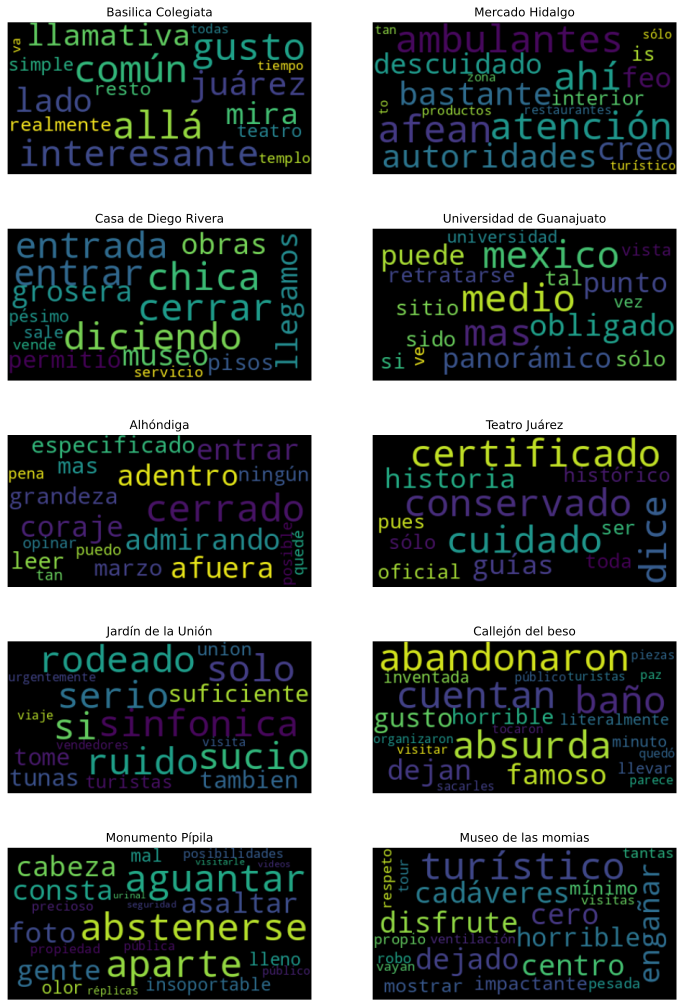

In [ ]:
plt.figure(figsize=(12, 18))
stopwords.update(["lugar","Guanajuato","México"])
for i in range(10):
  wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=25, background_color="black").generate(" ".join(words[i]))
  plt.subplot(5,2,i+1);plt.title(places[i])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
#plt.savefig('foo.png')
plt.show()



---
## **5**. Counstruimos para cada lugar 3 bolsas de palabras compuestas por las 1000 palabras con mayor tfidf, otra por los 2000 bigramas con mayor tfidf y 1000 trigramas con mayor tfidf, después hacemos una bolsa concatenada con éstas 3 y usamos *feature selection* para encontrar los 1000 términos más relevantes y mostrarlos en nubes de palabras para cada sitio.

### Unigramas

In [ ]:
opinions = filter(dataTurismo,None,None)
califCod = [dataTurismo[i]['Escala'] for i in range(10)]
vectorizer = [TfidfVectorizer(min_df = 2,stop_words = 'english',lowercase=True,norm='l2') for i in range(10)]
BOW_unigr = [vectorizer[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]

<ipython-input-217-2b5a2faf4c01>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opinions[i]["Opinión"].iloc[k] = dataTurismo[i]["Opinión"].iloc[k].replace('"','')


In [ ]:
sum_tf = [np.sum(np.asarray(BOW_unigr[i].todense()),axis = 0) for i in range(10)]
ind = [sorted(np.argpartition(sum_tf[i], -760)[-760:]) for i in range(10)]
BOW_tot = [BOW_unigr[i].todense()[:,ind[i]] for i in range(10)]

values = [list(dicti[i].values()) for i in range(10)]
words = [[] for i in range(10)]
for i in range(10):
  for j in range(len(ind[i])):
    index = values[i].index(ind[i][j])
    words[i].append(list(dicti[i].keys())[index])

### Bigramas

In [ ]:
vectorizer_big = [TfidfVectorizer(min_df = 1,ngram_range = (2,2),stop_words = 'english',lowercase=True,norm='l2') for i in range(10)]
BOW_bigr = [vectorizer_big[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
dicti_big = [vectorizer_big[i].vocabulary_ for i in range(10)]
[len(dicti_big[i]) for i in range(10)]

[6113, 7526, 7372, 10637, 13755, 12170, 11101, 17723, 16690, 24615]

In [ ]:
sum_tf = [np.sum(np.asarray(BOW_bigr[i].todense()),axis = 0) for i in range(10)]
ind = [sorted(np.argpartition(sum_tf[i], -2000)[-2000:]) for i in range(10)]
BOW_big_r = [BOW_bigr[i].todense()[:,ind[i]] for i in range(10)]

values = [list(dicti_big[i].values()) for i in range(10)]
words_big = [[] for i in range(10)]
for i in range(10):
  for j in range(len(ind[i])):
    index = values[i].index(ind[i][j])
    words_big[i].append(list(dicti_big[i].keys())[index])

### Trigramas

In [ ]:
vectorizer_tri = [TfidfVectorizer(min_df = 1,ngram_range = (3,3),stop_words = 'english',lowercase=True,norm='l2') for i in range(10)]
BOW_tri = [vectorizer_tri[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
dicti_tri = [vectorizer_tri[i].vocabulary_ for i in range(10)]
[len(dicti_tri[i]) for i in range(10)]

[7763, 9669, 9676, 14710, 19432, 17133, 15631, 27101, 26100, 37283]

In [ ]:
sum_tf = [np.sum(np.asarray(BOW_tri[i].todense()),axis = 0) for i in range(10)]
ind = [sorted(np.argpartition(sum_tf[i], -1000)[-1000:]) for i in range(10)]
BOW_tri_r = [BOW_tri[i].todense()[:,ind[i]] for i in range(10)]

values = [list(dicti_tri[i].values()) for i in range(10)]
words_tri = [[] for i in range(10)]
for i in range(10):
  for j in range(len(ind[i])):
    index = values[i].index(ind[i][j])
    words_tri[i].append(list(dicti_tri[i].keys())[index])

### Concatenamos ahora nuestras bolsas de palabras y calculamos con selectKbest las mejores 1000 features, mostramos algunas de cada lugar.

In [ ]:
BOW_tot = [np.concatenate((BOW_tot[i],BOW_big_r[i],BOW_tri_r[i]),axis = 1) for i in range(10)]
words = [np.concatenate((np.array(words[i]),np.array(words_big[i]),np.array(words_tri[i])))for i in range(10)]
print(BOW_tot[0].shape,words[0].shape)

(316, 3760) (3760,)


In [ ]:
best = [0 for i in range(10)]
for i in range(10):
  feats = SelectKBest(chi2, k=1000)
  feats.fit(np.asarray(BOW_tot[i]), califCod[i])
  best[i] = feats.get_support(indices=True)

f_words = [[0 for i in range(1000)] for i in range(10)]
for j in range(10):
  for i in range(1000):
    f_words[j][i] = words[j][best[j][i]]
len(f_words[0])

1000

In [ ]:
for i in range(10):
  print("\n",places[i],":\n",[f_words[i][37:41],f_words[i][546:552],f_words[i][863:868]])


 Basilica Colegiata :
 [['casarse', 'casi', 'central', 'centro'], ['méxico en', 'nadie le', 'nieves muy', 'noche celebrándose', 'noche es', 'noche está'], ['la ciudad guanajuato', 'la ciudad iglesia', 'la ciudad tanto', 'la hace lucir', 'la iglesia toda']]

 Mercado Hidalgo :
 [['blusas', 'bonita', 'bonito', 'buen'], ['lugar poco', 'lugar turístico', 'lugar típico', 'lugares pintorescos', 'mal además', 'mal aunque'], ['little worse reason', 'lleno artesanías típicas', 'lo había visitado', 'lo particular gusto', 'lo que la']]

 Casa de Diego Rivera :
 [['audio', 'auditorio', 'autor', 'autores'], ['interesante pero', 'interesante por', 'interesantes al', 'ir la', 'la ambientación', 'la cantidad'], ['es muy interesante', 'es muy linda', 'es más bien', 'es personaje que', 'es una casa']]

 Universidad de Guanajuato :
 [['bellas', 'bellos', 'bonita', 'bonitas'], ['esta lleno', 'esta muy', 'estado guanajuato', 'estar en', 'este edificio', 'estructura impactó'], ['es el lugar', 'es impresion

### Por último, encontramos los 50 features más relevantes y los mostramos en nubes de palabras para cada sitio cambiando los espacios en los bigramas y trigramas por _. 

In [ ]:
best = [0 for i in range(10)]
for i in range(10):
  feats = SelectKBest(chi2, k=50)
  feats.fit(np.asarray(BOW_tot[i]), califCod[i])
  best[i] = feats.get_support(indices=True)
best[4][:21]

array([  85,   91,  100,  106,  173,  205,  351,  416,  474,  493,  494,
        576,  594,  648,  651,  708,  731, 1097, 1161, 1248, 1291])

In [ ]:
f_words = [[0 for i in range(50)] for i in range(10)]
for j in range(10):
  for i in range(50):
    f_words[j][i] = words[j][best[j][i]].replace(" ","_")
len(f_words[0])

50

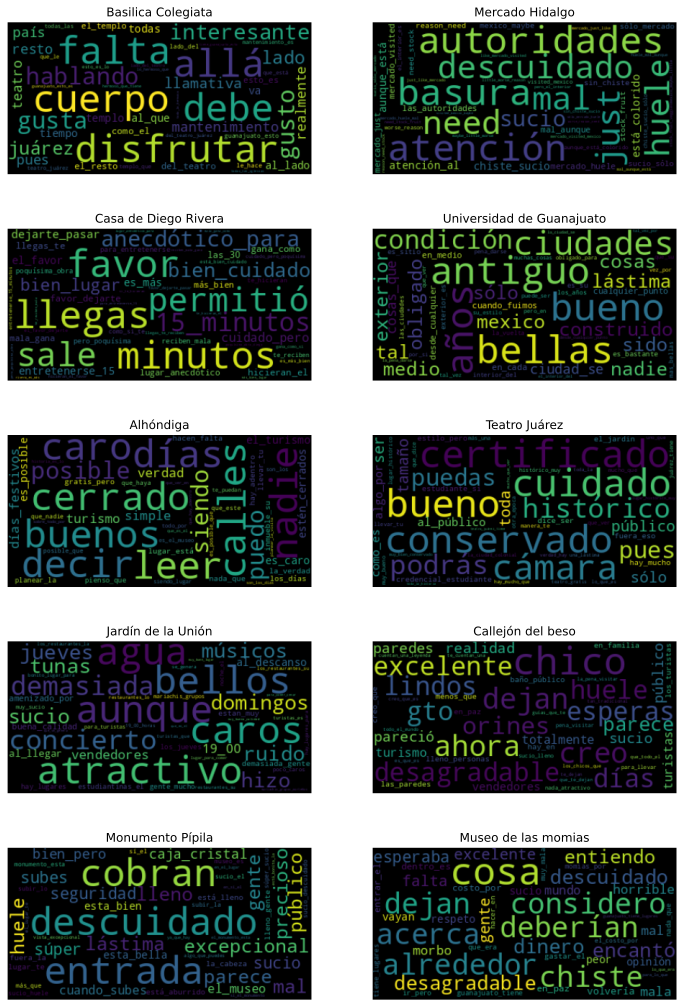

In [ ]:
plt.figure(figsize=(12, 18))
stopwords.update(["lugar","Guanajuato","México"])
for i in range(10):
  wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=50, background_color="black",collocations=True, min_word_length=1).generate(" ".join(f_words[i]))
  plt.subplot(5,2,i+1);plt.title(places[i])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
#plt.savefig('foo.png')
plt.show()

## **6**. Contamos ahora la ocurrencia temporal de las 10 palabras con mayor ganancia de información por lugar. Para ello calculamos las 10 palabras más relevantes por lugar usando toda la base de datos y contamos la frecuancia que tuvieron esas palabras por cada año, desde 2008 hasta 2018, que son los años que abarca esta base de datos.

In [ ]:
opinions = filter(dataTurismo,None,None)
califCod = [dataTurismo[i]['Escala'] for i in range(10)]
vectorizer = [TfidfVectorizer(min_df = 5,stop_words = 'english',lowercase=True,norm='l2') for i in range(10)]
BOW_Trip = [vectorizer[i].fit_transform(opinions[i]["Opinión"]) for i in range(10)]
dicti = [vectorizer[i].vocabulary_ for i in range(10)]
[len(dicti[i] )for i in range(10)]

<ipython-input-5-2595ce534633>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opinions[i]["Opinión"].iloc[k] = dataTurismo[i]["Opinión"].iloc[k].replace('"','')


[283, 349, 330, 479, 606, 593, 528, 751, 733, 1027]

In [ ]:
best = [0 for i in range(10)]
for i in range(10):
  feats = SelectKBest(chi2, k=17)
  feats.fit(np.asarray(BOW_Trip[i].todense()), califCod[i])
  best[i] = feats.get_support(indices=True)
best[4][:21]

array([ 25,  69,  80,  85, 137, 161, 330, 339, 378, 394, 395, 461, 473,
       500, 563, 571, 582])

In [ ]:
values = [list(dicti[i].values()) for i in range(10)]
words = [[] for i in range(10)]
for i in range(10):
  for j in range(len(best[i])):
    index = values[i].index(best[i][j])
    words[i].append(list(dicti[i].keys())[index])

In [ ]:
tokenizer = TweetTokenizer()
f_words = [[words[j][i] for i in range(len(words[j])) if words[j][i] not in stopwords][:10] for j in range(10)]

freqt = np.zeros((10,len(f_words[0]),11))
for i in range(10):
  for k in range(len(f_words[i])):
    for j in range(len(opinions[i])):
      if f_words[i][k] in tokenizer.tokenize(opinions[i]["Opinión"].iloc[j]):
        freqt[i,k,int(str(opinions[i].Fecha.iloc[j])[2:4])-8] +=1

### Graficamos ahora la ocurrencia de las 10 palabras por lugar, usando dos gráficas de cada lugar para que se vea con más claridad.

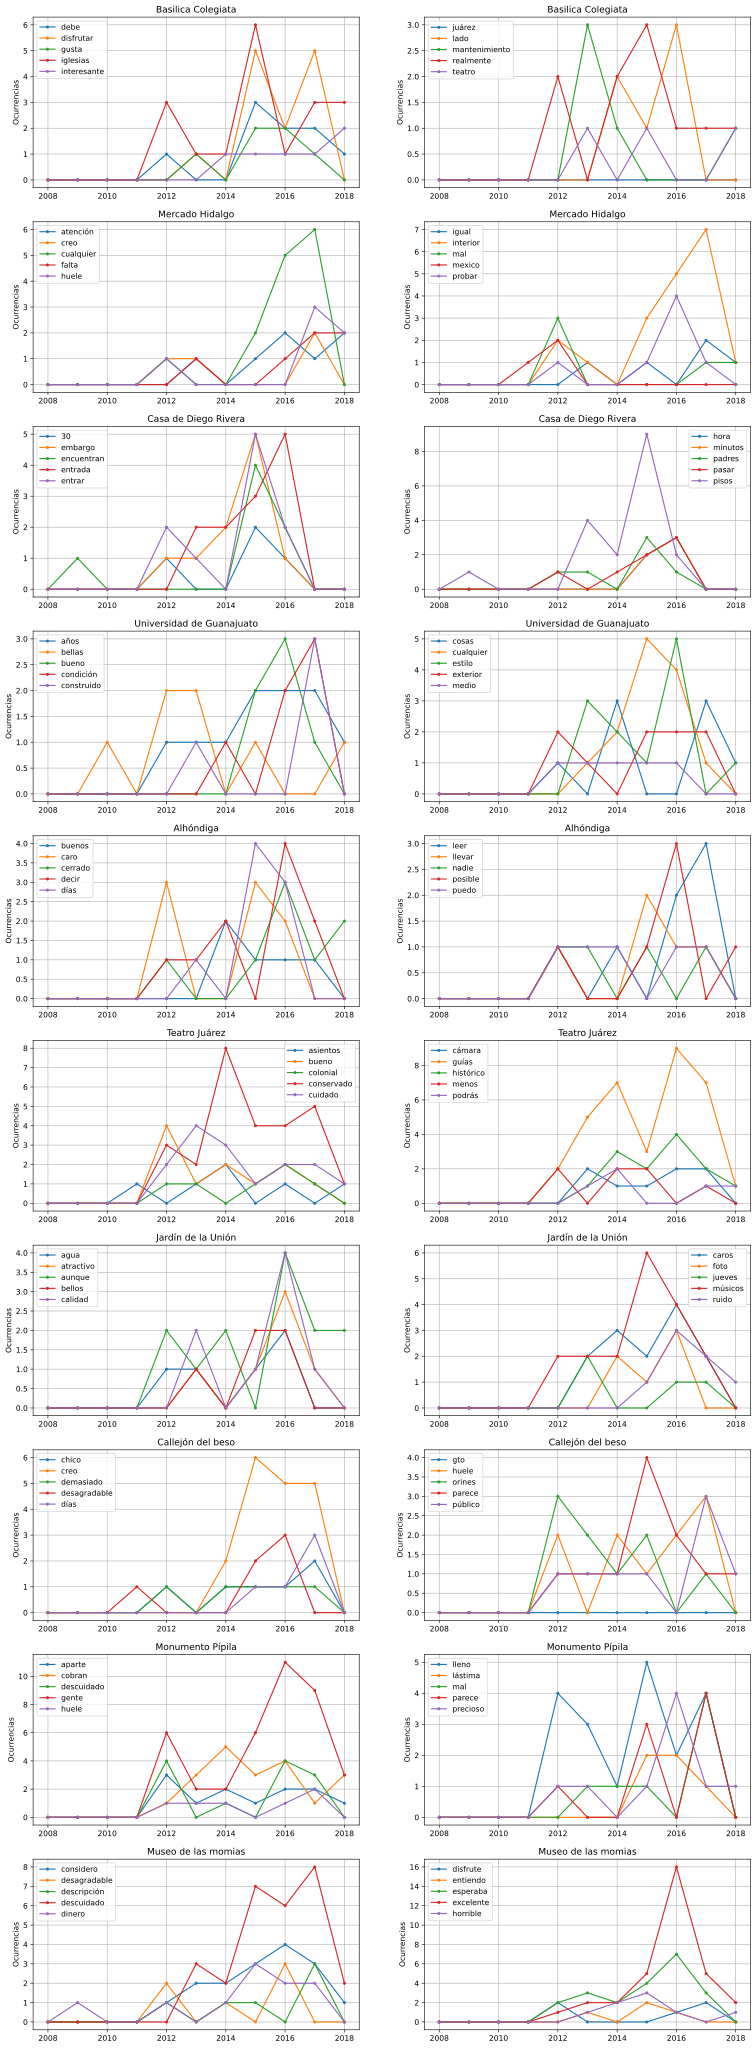

In [ ]:
plt.figure(figsize=(17, 48))
aux = 1
for i in range(10):
  for j in range(5):
    plt.subplot(10, 2, aux);plt.title(places[i]);plt.grid();plt.ylabel("Ocurrencias")
    plt.plot(np.arange(2008,2019,1,dtype = int),np.array(freqt[i][j],dtype = int),
            marker=".",label = f_words[i][j])
    plt.legend()
  aux+=1
  for j in range(5,10):
    plt.subplot(10, 2, aux);plt.title(places[i]);plt.grid();plt.ylabel("Ocurrencias")
    plt.plot(np.arange(2008,2019,1,dtype = int),np.array(freqt[i][j],dtype = int),
            marker=".",label = f_words[i][j])
    plt.legend()
  aux+=1

plt.show()

## **7**. Ahora analizamos opiniones negativas y positivas respecto del tiempo de 2008 a 2018. Nos ayudamos de un gráfico de barras para cada sitio turístico con las proporciones de opiniones negativas, neutras y positivas. Colocamos una escala logarítmica sobre las gráficas para poder apreciar las tendencias aunque las proporciones no sean tan intuitivas.

In [ ]:
dataTurismo = [pd.read_excel("/content/drive/MyDrive/Colab Notebooks/turismo/Opiniones Tripadvisor_nlp2023.xlsx", sheet_name=i, header=0) for i in range(10)]
dat = [np.asarray(dataTurismo[i].Escala) for i in range(10)]
for i in range(10):
  for j in range(len(dat[i])):
    d = dat[i][j].copy()
    if d == 3:
      dat[i][j] = 1
    elif d < 3:
      dat[i][j] = 2
    else:
      dat[i][j] = 0

In [ ]:
freqt = np.zeros((10,3,11))
for i in range(10):
  for j in range(len(dat[i])):
    if dat[i][j] != 0:
      if dat[i][j] == 2:
        freqt[i,2,int(str(dataTurismo[i].Fecha.iloc[j])[2:4])-8] +=1
      else:
        freqt[i,1,int(str(dataTurismo[i].Fecha.iloc[j])[2:4])-8] +=1
    else:
      freqt[i,0,int(str(dataTurismo[i].Fecha.iloc[j])[2:4])-8] +=1

In [ ]:
percent = np.zeros((10,3,11),dtype = int)
for i in range(10):
  for j in range(3):
    for k in range(11):
      su = freqt[i,0,k]+freqt[i,1,k]+freqt[i,2,k]
      if su != 0:
        percent[i,j,k] = round(freqt[i,j,k]*100/su,0)

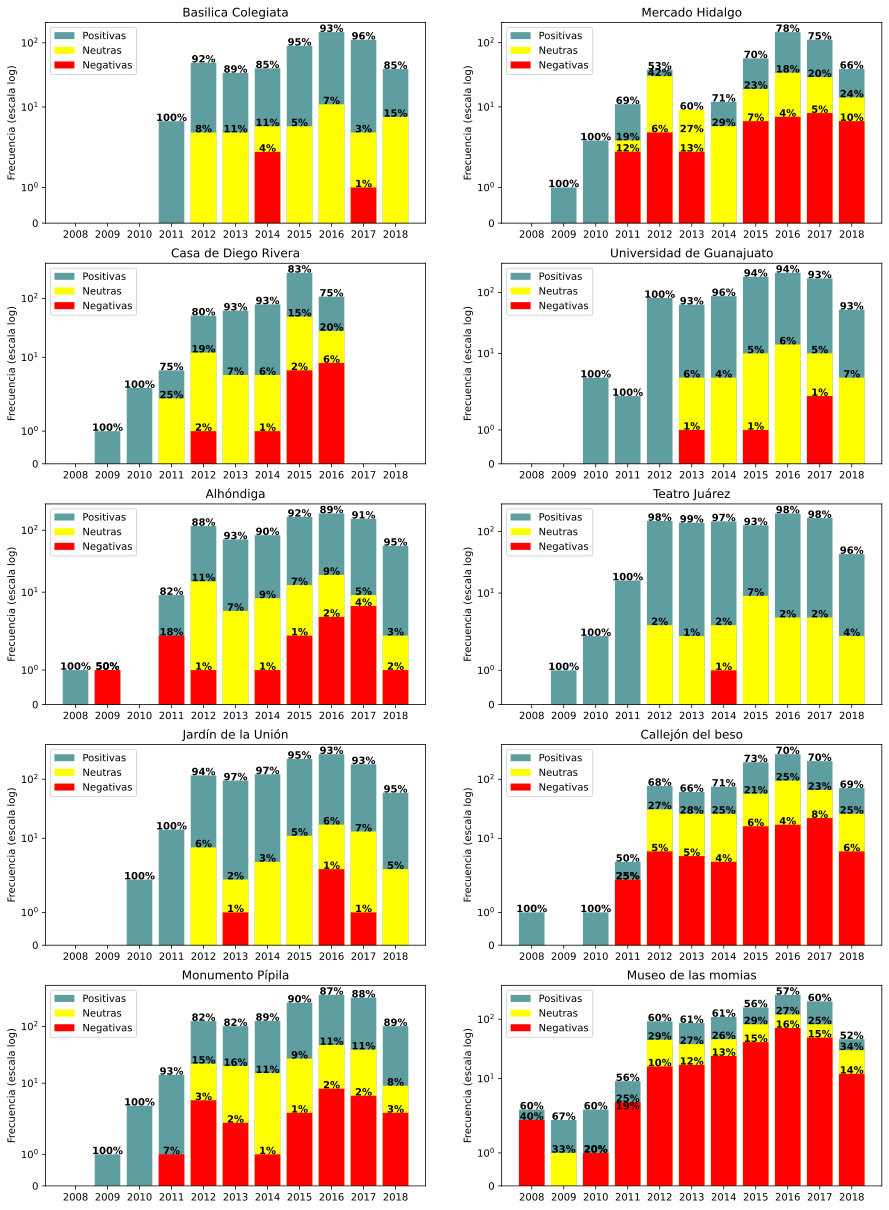

In [ ]:
plt.figure(figsize=(15, 21))
lab = ["Positivas","Neutras","Negativas"]
col = ["cadetblue","yellow","red"]

for i in range(10):
  plt.subplot(5,2,i+1)
  for kk in range(3):
    graph = plt.bar(np.arange(2008,2019,1),np.array(freqt[i,kk]), color = col[kk],label = lab[kk])

    for j,p in enumerate(graph):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        if percent[i,kk,j]!=0:
          plt.text(x+width/2,
              y+height*1.01,
              str(percent[i,kk,j])+'%',
              ha='center',
              weight='bold')

  plt.yscale('symlog');plt.ylabel("Frecuencia (escala log)");plt.title(places[i]);plt.legend();plt.xticks(np.arange(2008,2019,1))
plt.show()

# **Preguntas**

## 1.¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de ello?


---

### Parece ser que el museo de las momias causa más polémica que los demás sitios, ya que, no solo es el lugar que más opiniones en general tiene, si no que es muy polémico en cuanto a la proporción de opiniones negativas que tiene respecto a las positivas comparado con los otros sitios. Los visitantes que valoraron positivamente parecen haber disfrutado del morbo y de la historia. Sin embargo, los que no lo disfrutaron parecen quejarse del precio, del descuido , de lo desagradable de la experiencia y de no encontrarle el chiste al lugar. Hay que contemplar también que es de los pocos lugares que marcan una frecuencia de opiniones alta durante todos los años que cubre la base de datos, tanto de hombre como mujeres, tanto de turistas internacionales o nacionales. Parece ser que al ser más desagradable la experiencia en general para los turistas, es más probable que se exprese una opinión, por lo que tal vez podríamos establecer una relación entre polémico y Negativo.

## 2. En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre turistas nacionales e internacionales?


---
### En cuanto a turismo nacional respecto al internacional vemos que los nacionales parecen disfrutar de la guía, les es agradable, sin embargo se quejan de lo angosto de los pasillos, de las restricciones y del mal olor en el museo, mientras que a los internacionales parece molestarles la poca seriedad del lugar debido al tópico del sitio, así mismo parece que les molesta el tiempo, ya sea por lo tardado que fue entrar al lugar o el poco tiempo del recorrido. Sin embargo parece que tanto turistas nacionales como internacionales tienen una mala impresión de la experiencia.

## 3. ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?
---
### No es claro cuál podría ser el lugar que las mujeres más disfrutan, sin embargo, existen dos sitios que tienen un significativo promedio mayor de calificación que los demás si comparamos las evaluaciones de las mujeres con las de los hombres, estos son la Basílica y la Casa de Diego Rivera, que coinciden también con dos de los lugares que más aceptación tienen en general. Intentando analizar las palabras más relevantes del género encontramos que tal vez las mujeres están apreciando más la estética de los lugares que los hombres, se usa mucho historíco, hermoso, y bien conservado. Probablemente las mujeres turistas han valorado más el arte y lo visual por encima de la experiencia, motivo por el cual los hombres parecen no opinar tan positivamente de los lugares, ya que parecen de nuevo quejarse del precio.

## 4. ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?
---
### Parece existir una significativa mayor participación de opiniones jóvenes en el Callejón del beso y en la Universidad de Guanajuato, sin embargo, el callejón del beso tiene una alta proporción de opiniones negativas que hacen referencia al descuido, parece que la gente se queja de las paredes están grafiteadas y que el olor no es agradable, en general, aunque tenga una gran afluencia jóven, parece tener ser visto de forma muy negativa, por otro lado, la universidad de Guanajuato no es de los lugares que más opiniones tiene, sin embargo, muchas de ellas son de jóvenes, esto debido seguramente a que muchos son propios estudiantes y analizando las palabras más representativas parece que se asocia con las callejoneadas y eventos culturales que son del agrado del segmento joven, a parte de que parecen calificar estéticamente a la universidad como hermosa y bella. Por lo que podríamos decir que es el lugar que más disfrutan los jóvenes.

## 5. ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)
---
### Existen algunos lugares que tienen una proporción elevada de opiniones negativas respecto de los más valorados positivamente. Entre ellos encontramos principalmente el Mercado Hidalgo, El museo de las momias y el callejón del beso. Las quejas más representativas hacen referencia al precio elevado, a lo descuidado de los lugares, al mal olor, a lo sucio que se está, a lo poco que gustaron sus alimentos (Mercado) y parece que existe disconformidad con el hecho del descuento a la gente que puede comprobar que es de Guanajuato. Se quejan también de ciertas reglas o prohibiciones dentro de los sitios, así como de cobros extra.
### En cuanto a lo que les gusta a los turistas parece que no se encuentran muchos motivos diferentes, la mayoría hacen referencia a atributos estéticos, en todos los sitios se hace referencia a lo hermoso, bello y otros adjetivos similares, otra vertiente le da mucho valor al aspecto histórico aportado en sitios que tienen relación directa con la historia del país, como la Alhóndiga, Las momias y los museos. Una última vertiente parece estar en las personas que valoran la estética artística de museos y de la basílica. Cabe agregar también que hay personas que se quejan de que ciertos lugares se encuentran cerrados en ciertos días no convenientes.
